### Evaluation File

#### In this file we will show the evaluation results of various models (self-built and open source) on the Road Dataset

In [4]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from PIL import Image

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Make a colourmap to display all the colours

In [9]:
def apply_colormap(class_map, num_classes=39):
    cmap = plt.cm.get_cmap('tab20', num_classes)
    colored_result = cmap(class_map / num_classes) 
    colored_result = colored_result[:, :, :3] 
    
    return (colored_result * 255).astype(np.uint8)

## Define the Image Transformations

In [12]:
image_transforms = transforms.Compose([
    transforms.Resize((224 , 224)) , 
    transforms.ToTensor()
    ])

#### Model 1) Self-Built : U-Net with pretrained ResNet-34 Backbone

class UNet(nn.Module):
    
    def __init__(self, n_classes=2):
        super(UNet, self).__init__()
        
        self.n_classes = n_classes
        self.pretrained_backbone = models.resnet18(pretrained=True)
        self.layers = list(self.pretrained_backbone.children())
        
       
        self.downsample_1 = nn.Sequential(*self.layers[0:3])  # 1 x 64 x 112 x 112
        self.downsample_2 = nn.Sequential(*self.layers[3:5])  # 1 x 64 x 56 x 56
        self.downsample_3 = self.layers[5]  # 1 x 128 x 28 x 28
        self.downsample_4 = self.layers[6]  # 1 x 256 x 14 x 14
        self.downsample_5 = self.layers[7]  # 1 x 512 x 7 x 7
        
       
        self.up_conv_1 = self.upConv(512, 256)
        self.decoder_1 = self.DoubleConv(512, 256)
        
        self.up_conv_2 = self.upConv(256, 128)
        self.decoder_2 = self.DoubleConv(256, 128)
        
        self.up_conv_3 = self.upConv(128, 64)
        self.decoder_3 = self.DoubleConv(128, 64)  # 1 x 64 x 56 x 56
        
        self.up_conv_4 = self.upConv(64, 64)
        self.decoder_4 = self.DoubleConv(128, 64)  # 1 x 64 x 112 x 112
        
        self.up_conv_5 = self.upConv(64, 64)  # 1 x 64 x 224 x 224
        
        self.final = nn.Conv2d(64, self.n_classes, kernel_size=1)
        
    def forward(self, x):
        
        enc1 = self.downsample_1(x)  # 1 x 64 x 112 x 112
        enc2 = self.downsample_2(enc1)  # 1 x 64 x 56 x 56
        enc3 = self.downsample_3(enc2)  # 1 x 128 x 28 x 28
        enc4 = self.downsample_4(enc3)  # 1 x 256 x 14 x 14
        enc5 = self.downsample_5(enc4)  # 1 x 512 x 7 x 7
        
        up1 = self.up_conv_1(enc5)  # 1 x 256 x 14 x 14
        dec1 = self.decoder_1(torch.cat([enc4, up1], dim=1))  # 1 x 256 x 14 x 14
        
        up2 = self.up_conv_2(dec1)  # 1 x 128 x 28 x 28
        dec2 = self.decoder_2(torch.cat([enc3, up2], dim=1))  # 1 x 128 x 28 x 28
        
        up3 = self.up_conv_3(dec2)  # 1 x 64 x 56 x 56
        dec3 = self.decoder_3(torch.cat([enc2, up3], dim=1))  # 1 x 64 x 56 x 56
        
        up4 = self.up_conv_4(dec3)  # 1 x 64 x 112 x 112
        dec4 = self.decoder_4(torch.cat([enc1, up4], dim=1))  # 1 x 64 x 112 x 112
        
        up5 = self.up_conv_5(dec4)  # 1 x 64 x 224 x 224

        output = self.final(up5)

        
        return output

    def DoubleConv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  
            nn.ReLU(inplace=True)
        )

    def upConv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

##### Load the model into device. Display a batch of images from the test dataset and calculate IOU and Pixelwise Accuracy from the validation datset

In [16]:
model = torch.load("model_checkpoint.pth")
model = model.to(device)

C:\Users\jishu\AppData\Local\Temp\ipykernel_28004\3789615479.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


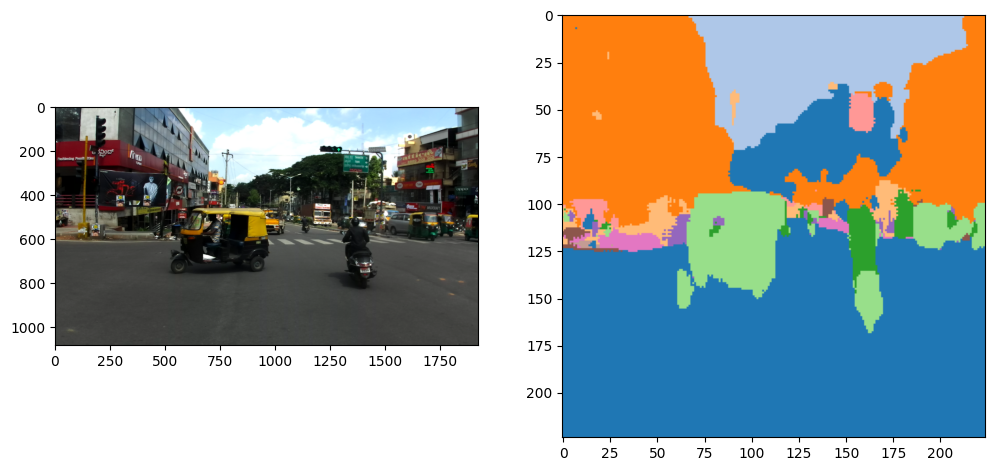

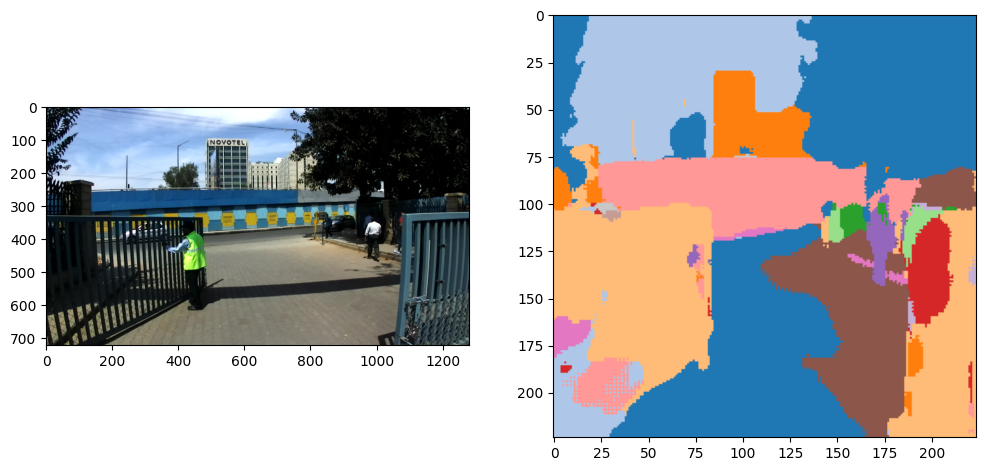

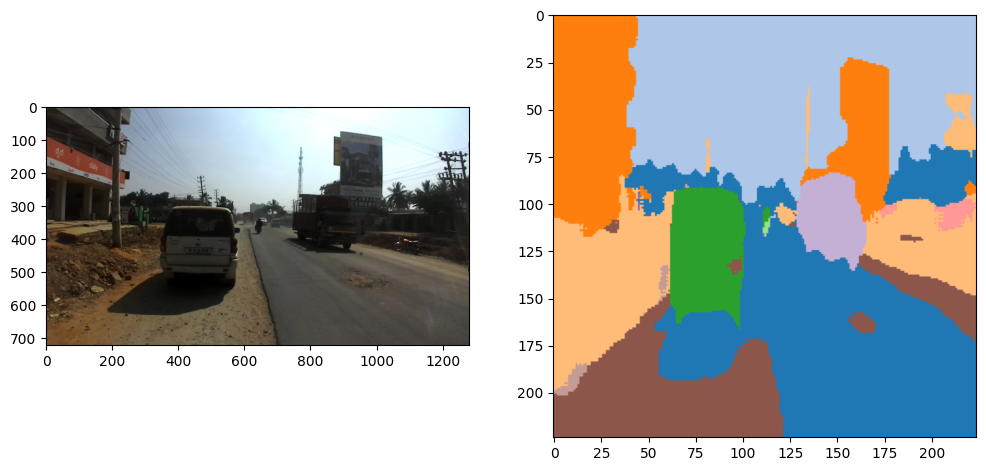

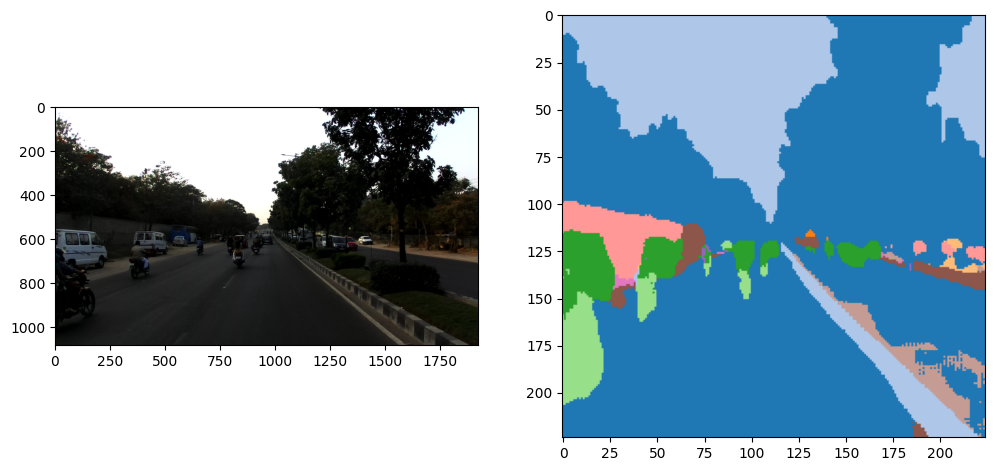

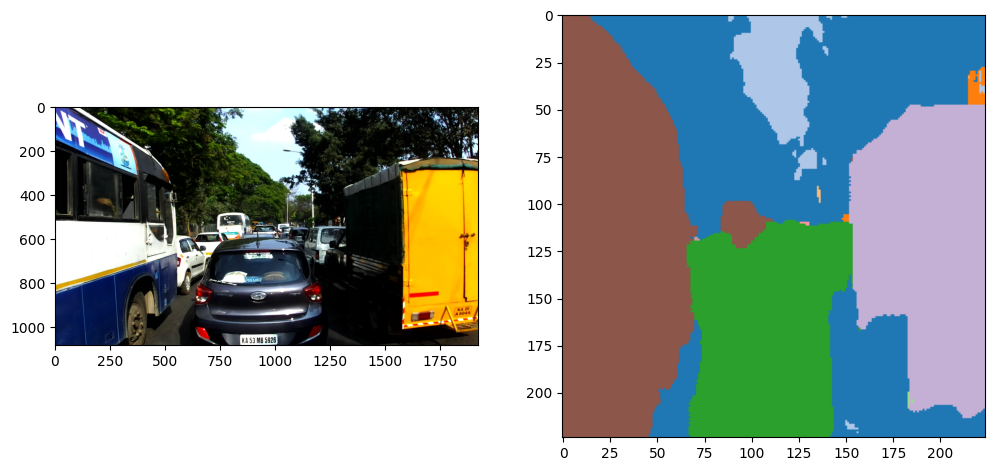

In [17]:
# Display the Results
root_dir = r'C:\Users\jishu\Documents\InterIITtask\Task_2_Segmentation\IDD_Segmentation\leftImg8bit\test'

folder_count = 0

for image_folders in os.listdir(root_dir):
    if(folder_count == 5):
        break
    path = os.path.join(root_dir, image_folders)
    for images_path in os.listdir(path):
        final_img_path = os.path.join(path, images_path)
        original_image = Image.open(final_img_path).convert('RGB')
        

        image = (image_transforms(original_image).unsqueeze(0)).to(device) 
        result = model(image)
        result = result.squeeze(0).cpu().detach().numpy()
        class_map = np.argmax(result, axis=0) 
        
        colored_image = apply_colormap(class_map, num_classes=39)
        
        pil_image = Image.fromarray(colored_image)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(original_image)
        axes[1].imshow(colored_image)

        plt.show()
        folder_count += 1
        break
        

#### Model 2) Self-Built : U-Net with pretrained ResNet-101 Backbone

1class UNet(nn.Module):
    def __init__(self, n_classes=2):
        super(UNet, self).__init__()

        self.n_classes = n_classes
        self.pretrained_backbone = models.resnet101(pretrained=True)
        self.layers = list(self.pretrained_backbone.children())
        
        self.downsample_1 = nn.Sequential(*self.layers[0:4])  # 64 x 56 x 56
        self.downsample_2 = self.layers[4]                    # 256 x 56 x 56
        self.downsample_3 = self.layers[5]                    # 512 x 28 x 28
        self.downsample_4 = self.layers[6]                    # 1024 x 14 x 14
        self.downsample_5 = self.layers[7]                    # 2048 x 7 x 7
        

        self.up_conv_1 = self.upConv(2048, 1024)
        self.decoder_1 = self.DoubleConv(2048, 1024)
        self.up_conv_2 = self.upConv(1024, 512)
        self.decoder_2 = self.DoubleConv(1024, 512)
        self.up_conv_3 = self.upConv(512, 256)
        self.decoder_3 = self.DoubleConv(512, 256)
        self.up_conv_4 = self.upConv(256, 64)
        self.decoder_4 = self.DoubleConv(128, 64)

        self.up_conv_5 = self.upConv(64, 64)


        self.upsample_x1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.final = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def upConv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def DoubleConv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x1 = self.downsample_1(x)  # 64 x 56 x 56
        x2 = self.downsample_2(x1) # 256 x 56 x 56
        x3 = self.downsample_3(x2) # 512 x 28 x 28
        x4 = self.downsample_4(x3) # 1024 x 14 x 14
        x5 = self.downsample_5(x4) # 2048 x 7 x 7
        

        x = self.up_conv_1(x5)     # 1024 x 14 x 14
        x = torch.cat([x, x4], dim=1)
        x = self.decoder_1(x)
        
        x = self.up_conv_2(x)      # 512 x 28 x 28
        x = torch.cat([x, x3], dim=1)
        x = self.decoder_2(x)
        
        x = self.up_conv_3(x)      # 256 x 56 x 56
        x = torch.cat([x, x2], dim=1)
        x = self.decoder_3(x)
        
        x = self.up_conv_4(x)      # 64 x 112 x 112
        x1_upsampled = self.upsample_x1(x1)  
        x = torch.cat([x, x1_upsampled], dim=1)  
        x = self.decoder_4(x)   
        
        x = self.up_conv_5(x)      # 64 x 224 x 224
        
      
        x = self.final(x)
        return x

In [19]:
model = torch.load("model_checkpoint2.pth")
model = model.to(device)

C:\Users\jishu\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\jishu\AppData\Local\Temp\ipykernel_28004\3789615479.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


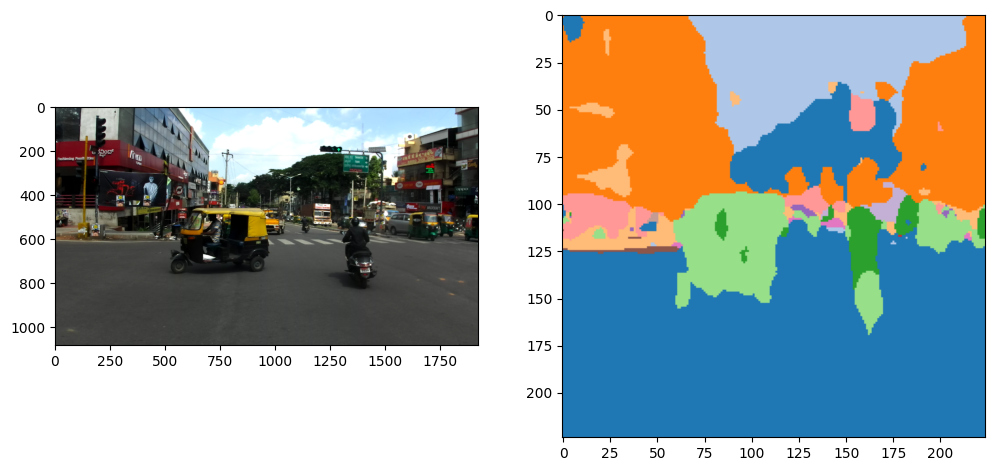

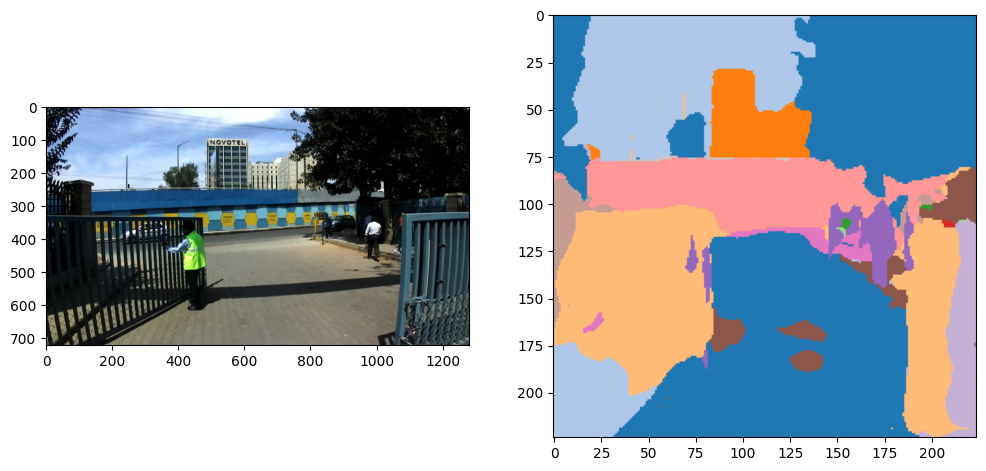

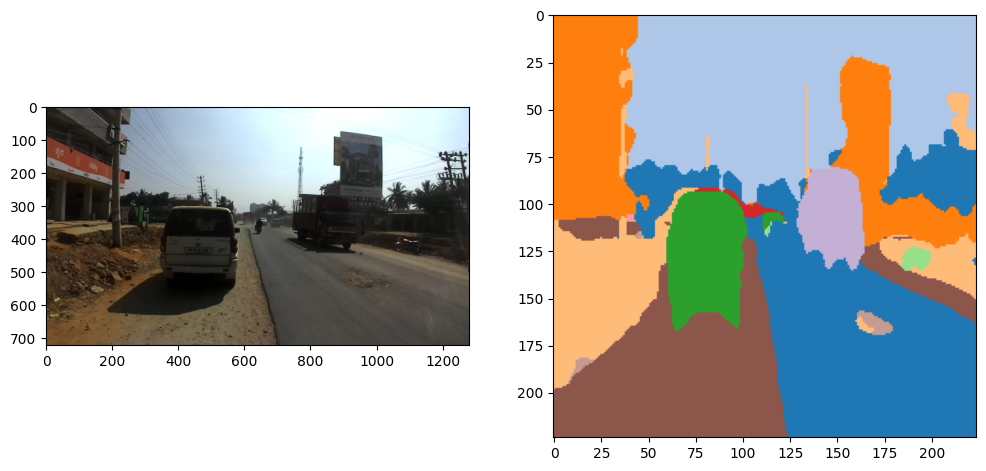

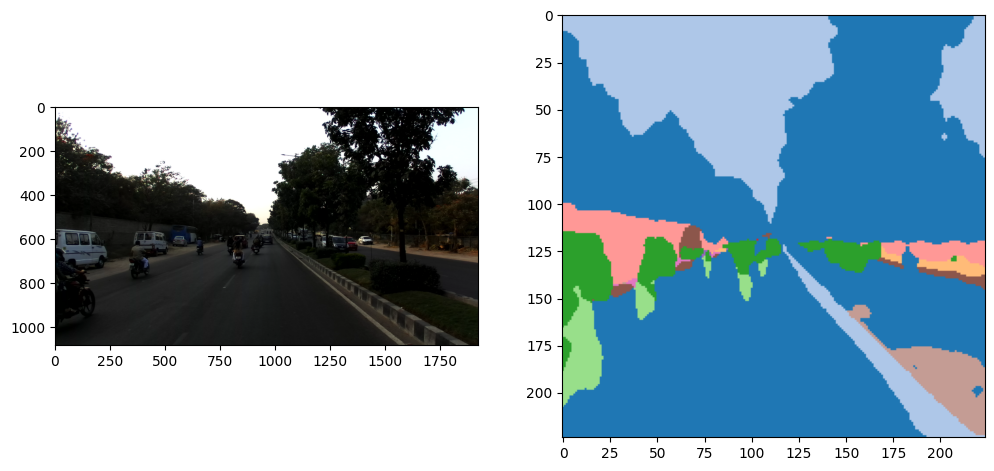

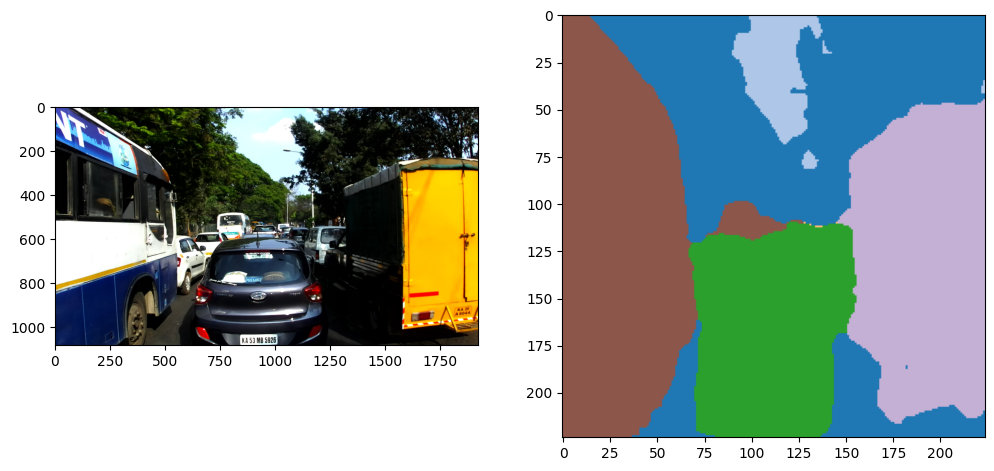

In [20]:
# Display the Results
root_dir = r'C:\Users\jishu\Documents\InterIITtask\Task_2_Segmentation\IDD_Segmentation\leftImg8bit\test'

folder_count = 0

for image_folders in os.listdir(root_dir):
    if(folder_count == 5):
        break
    path = os.path.join(root_dir, image_folders)
    for images_path in os.listdir(path):
        final_img_path = os.path.join(path, images_path)
        original_image = Image.open(final_img_path).convert('RGB')
        

        image = (image_transforms(original_image).unsqueeze(0)).to(device) 
        result = model(image)
        result = result.squeeze(0).cpu().detach().numpy()
        class_map = np.argmax(result, axis=0) 
        
        colored_image = apply_colormap(class_map, num_classes=39)
        
        pil_image = Image.fromarray(colored_image)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(original_image)
        axes[1].imshow(colored_image)

        plt.show()
        folder_count += 1
        break
        

#### Model 3) Open Source : Segment Anything 2 : From Meta

In [24]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[MODEL_TYPE](checkpoint='C:/Users/jishu/Documents/InterIITtask/Task_2_Segmentation/sam_vit_h_4b8939.pth')
sam.to(device=DEVICE)

# Initialize mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

C:\Users\jishu\AppData\Local\Temp\ipykernel_28004\2979403453.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab20', len(result))(idx)[:3]


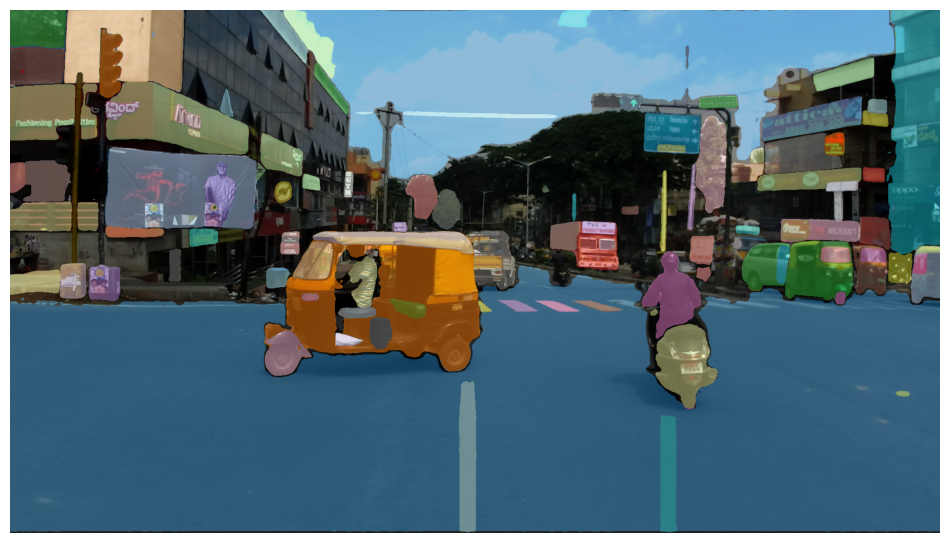

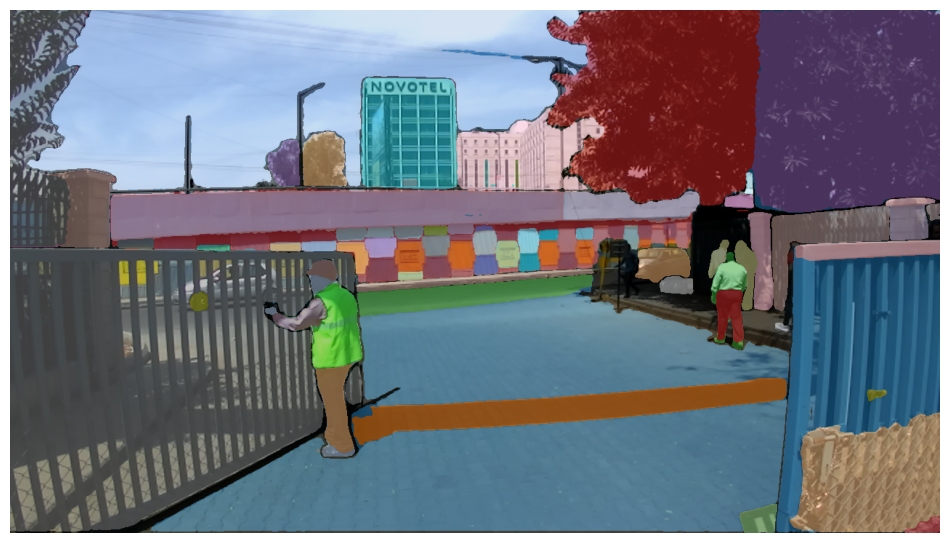

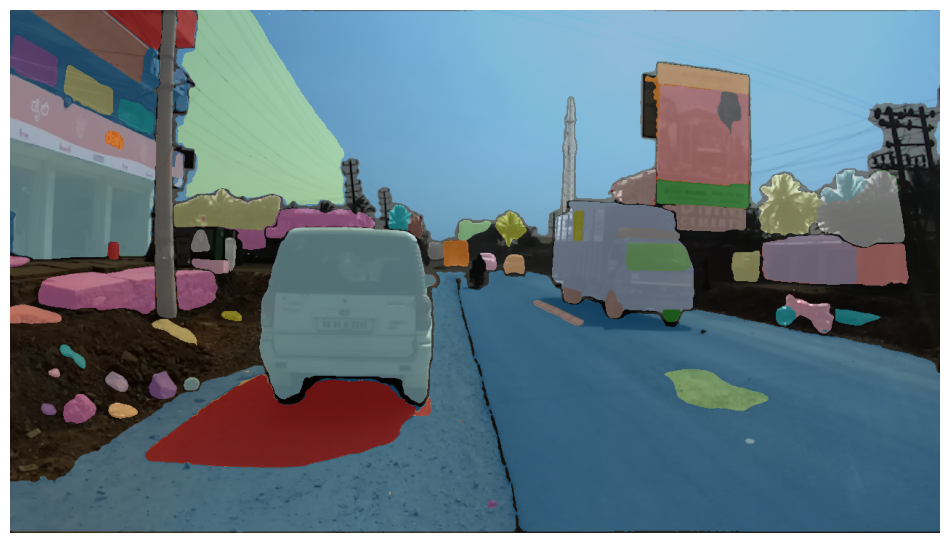

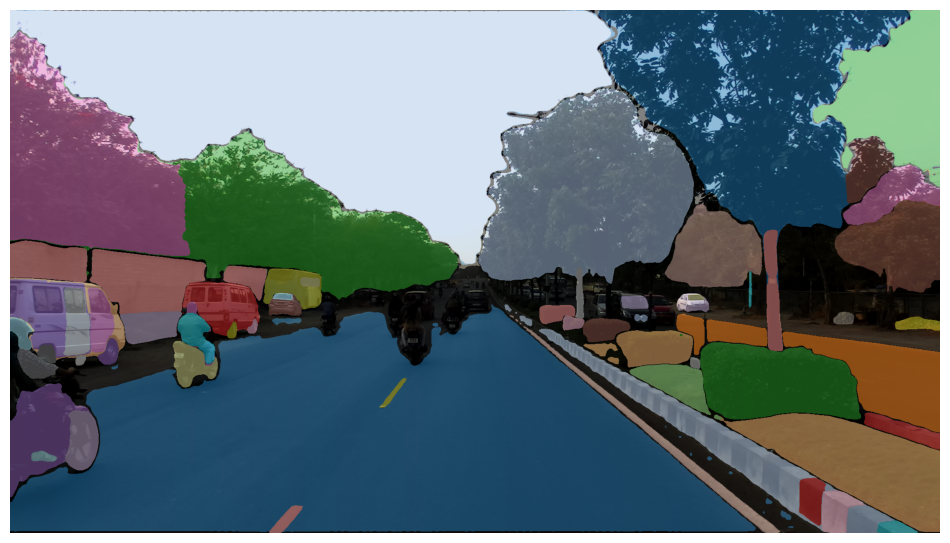

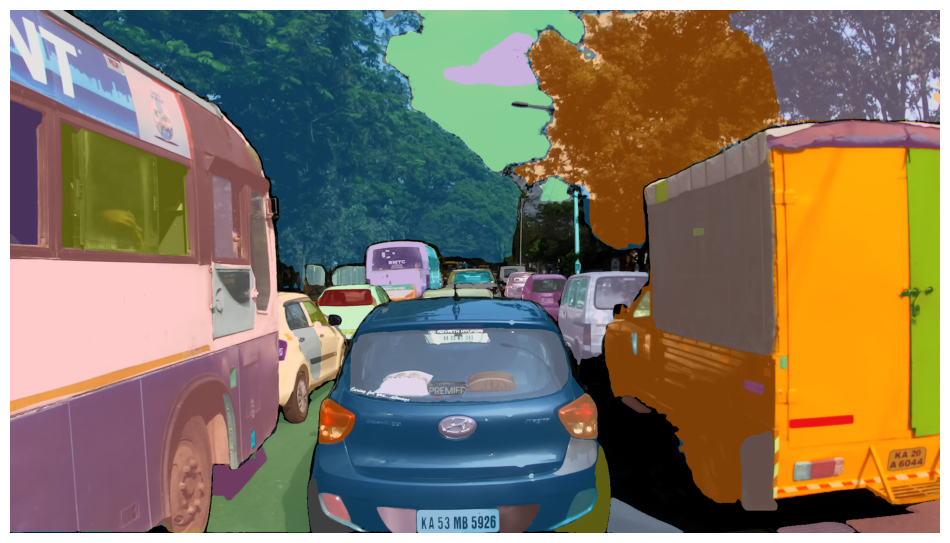

In [26]:
folder_count = 0 
for image_folders in os.listdir(root_dir):
    path = os.path.join(root_dir, image_folders)
    if folder_count == 5:
        break 
    for images_path in os.listdir(path):
        final_img_path = os.path.join(path, images_path)
        image_bgr = cv2.imread(final_img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        result = mask_generator.generate(image_rgb)
        combined_mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(image_rgb)
        
        for idx, example in enumerate(result):
            segmentation = example['segmentation']
            bbox = example['bbox']
            predicted_iou = example['predicted_iou']
            stability_score = example['stability_score']
        
            color = plt.cm.get_cmap('tab20', len(result))(idx)[:3]  
            color = (np.array(color) * 255).astype(np.uint8)  
            
            combined_mask_overlay[segmentation] = color
        
        ax.imshow(combined_mask_overlay, alpha=0.5)
    
        plt.axis('off')
        plt.show()

        folder_count += 1
        break 
   